# Medicare Physician and Other Supplier Data (Ophthamologists in CA)

In [2]:
import numpy as np
import pandas as pd

## Data Cleaning/Feature Engineering (1)

In [2]:
# Reading the data from 2012 to 2018

data2018 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2018_CA_Ophthalmology.csv')
data2017 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017_CA_Ophthalmology.csv')
data2016 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016_CA_Ophthalmology.csv')
data2015 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2015_CA_Ophthalmology.csv')
data2014 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2014_CA_Ophthalmology.csv')
data2013 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2013_CA_Ophthalmology.csv')
data2013 = data2013.rename(columns={'National Provider Identifier ':'National Provider Identifier'})
data2012 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2012_CA_Ophthalmology.csv')


In the following, we create a pivoted dataset in which every row represents a provider (denoted by its NPI) and every column corresponds to a specific HCPCS code done in a particular year between 2012 to 2018. Then, **each entry of this dataset represents the dollar amount paid by Medicare to that specific provider for that specific HCPCS code in a particular year.** Also, we add the fraud labels as the last column of this pivoted dataset. 

In [3]:
# Cleaning and pivoting the data (2012-2018)

def rem_comma(s):
    s1 = s.replace(',', '')
    return s1

def clean_pivot(data, period):
    
    data = data.sort_values(by=['National Provider Identifier'])
    
    if period == '2013':
        data['Number of Services'] = data['LINE_SRVC_CNT'].apply(rem_comma)
        data['Average Medicare Payment Amount'] = data['AVERAGE_MEDICARE_PAYMENT_AMT'].apply(rem_comma)
        data['HCPCS Code'] = data['HCPCS_CODE']
    else: 
        data['Number of Services'] = data['Number of Services'].apply(rem_comma)
        data['Average Medicare Payment Amount'] = data['Average Medicare Payment Amount'].apply(rem_comma)
        
    data['Number of Services'] = data['Number of Services'].apply(float)
    data['Average Medicare Payment Amount'] = data['Average Medicare Payment Amount'].apply(float)
    data['Medicare Payment Amount'] = data['Number of Services'] * data['Average Medicare Payment Amount']
    data = data.loc[:, ['National Provider Identifier', 'HCPCS Code', 'Medicare Payment Amount']]

    idx = 0
    while (idx + 1) < data.shape[0]:
        s = data.shape[0]
        NPI = data.iat[idx, 0]
        c = 1
        while idx + c < data.shape[0] and data.iat[idx + c, 0] == NPI:
            if data.iat[idx + c, 1] == data.iat[idx, 1]:
                data.iat[idx, 2] = data.iat[idx, 2] + data.iat[idx + c, 2]
                data = data.drop([idx + c])
                data = data.reset_index(drop=True)
                break
            else:
                c += 1
        if s == data.shape[0]:
            idx += 1 

    data_pivoted = data.pivot(index='National Provider Identifier', columns='HCPCS Code', values='Medicare Payment Amount')
    data_pivoted = data_pivoted.fillna(0)
    
    return data_pivoted

In [4]:
# 2018 pivoted data

data2018_copy = data2018.copy()
data2018_pivoted = clean_pivot(data2018_copy, '2018')

# 2017 pivoted data

data2017_copy = data2017.copy()
data2017_pivoted = clean_pivot(data2017_copy, '2017')

# 2016 pivoted data

data2016_copy = data2016.copy()
data2016_pivoted = clean_pivot(data2016_copy, '2016')

# 2015 pivoted data

data2015_copy = data2015.copy()
data2015_pivoted = clean_pivot(data2015_copy, '2015')

# 2014 pivoted data

data2014_copy = data2014.copy()
data2014_pivoted = clean_pivot(data2014_copy, '2014')

# 2013 pivoted data

data2013_copy = data2013.copy()
data2013_pivoted = clean_pivot(data2013_copy, '2013')

# 2012 pivoted data

data2012_copy = data2012.copy()
data2012_pivoted = clean_pivot(data2012_copy, '2012')

In [14]:
# Merging the data over different years

HCPCS_pool = set([*data2012_pivoted.columns, *data2013_pivoted.columns, *data2014_pivoted.columns, *data2015_pivoted.columns,
                  *data2016_pivoted.columns, *data2017_pivoted.columns, *data2018_pivoted.columns])
NPI_pool = set([*data2012_pivoted.index, *data2013_pivoted.index, *data2014_pivoted.index, *data2015_pivoted.index,
                  *data2016_pivoted.index, *data2017_pivoted.index, *data2018_pivoted.index])

data_pivoted = [data2012_pivoted.copy(), data2013_pivoted.copy(), data2014_pivoted.copy(), data2015_pivoted.copy(),
                data2016_pivoted.copy(), data2017_pivoted.copy(), data2018_pivoted.copy()]

for i in range(len(data_pivoted)):
    
    idx_list = set(data_pivoted[i].index)
    diff_idx_list = NPI_pool - idx_list
    for npi in diff_idx_list:
        data_pivoted[i].loc[npi] = 0.0
    
    clmn_list = set(data_pivoted[i].columns)
    diff_clmn_list = HCPCS_pool - clmn_list
    for hcpcs in diff_clmn_list:
        data_pivoted[i][hcpcs] = 0.0
        
    data_pivoted[i] = data_pivoted[i].reindex(sorted(data_pivoted[i].columns), axis=1)
    data_pivoted[i] = data_pivoted[i].sort_index()

index_list = data_pivoted[0].index
columns_list = data_pivoted[0].columns
data_merged = pd.DataFrame(index=index_list)
for hcpcs in columns_list:
    for i in range(len(data_pivoted)):
        year = str(i + 2012)
        column_name = hcpcs + '-' + year
        data_merged[column_name] = data_pivoted[i][hcpcs]     

data_merged.to_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_MP.csv')

In [19]:
# Adding the fraud labels to the merged dataset

data_merged = pd.read_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_MP.csv', index_col=0)

data_merged_labeled = data_merged.copy()
data_merged_labeled['Fraudulent'] = 0.0

fraud_npi_before = [1003816141, 1013010685, 1114913761, 1124131958, 1124150065, 1134232648, 1275626897, 
             1285622662, 1306023973, 1326230822, 1386989440, 1477573319, 1518046754, 1528054640, 
             1649316753, 1720096829, 1720123110, 1740210236, 1760566566, 1780609933, 1821273137, 
             1861470783, 1932270097]

fraud_npi_feb28 = [1013065184, 1023197241, 1043245624, 1043304280, 1063569655, 1104860691, 1124023999, 
                   1144225343, 1144226234, 1184741985, 1184783508, 1194732578, 1225189418, 1265531172, 
                   1285675629, 1750386546, 1285782847, 1346384864, 1376584599, 1467596114, 1477574200, 
                   1477596096, 1487680328, 1487682423, 1508801028, 1518977222, 1518989862, 1528048584, 
                   1538356001, 1548289671, 1558391342, 1558449850, 1568403970, 1578659405, 1598936395, 
                   1710970264, 1720082563, 1730154592, 1730298373, 1740388982, 1750356754, 1770503161, 
                   1831128362, 1841222023, 1841268273, 1912094376, 1922035559, 1972501237, 1982629010, 
                   1982685327, 1992768345]

fraudulent_npi = [*fraud_npi_before, *fraud_npi_feb28]
for i in range(len(fraudulent_npi)):
    data_merged_labeled.at[fraudulent_npi[i], 'Fraudulent'] = 1.0

## Data Analysis

In what follows, we perform a few unsupervised methods on the merged dataset to see how separable the data is. 

### PCA

In [20]:
%matplotlib notebook
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [21]:
X = data_merged_labeled.loc[:, data_merged_labeled.columns[0:-1]].values
y = data_merged_labeled.loc[:, 'Fraudulent'].values
X = StandardScaler().fit_transform(X)

#### 2-component PCA

<IPython.core.display.Javascript object>


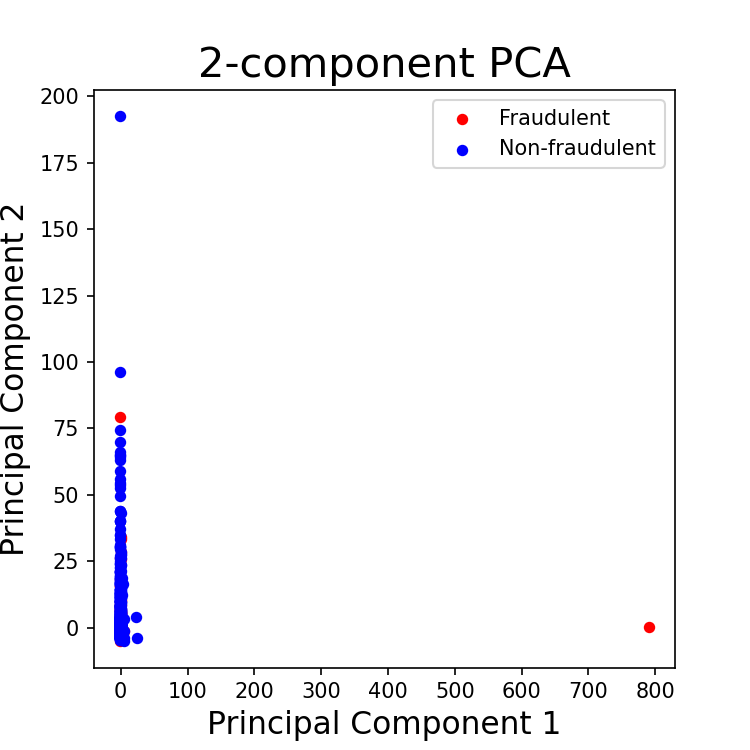

In [22]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
pcdf = pd.DataFrame(data=pcs, columns=['pc1', 'pc2'])
pcdf['Fraudulent'] = data_merged_labeled['Fraudulent'].values

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2-component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pcdf['Fraudulent'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

#### 3-component PCA

<IPython.core.display.Javascript object>


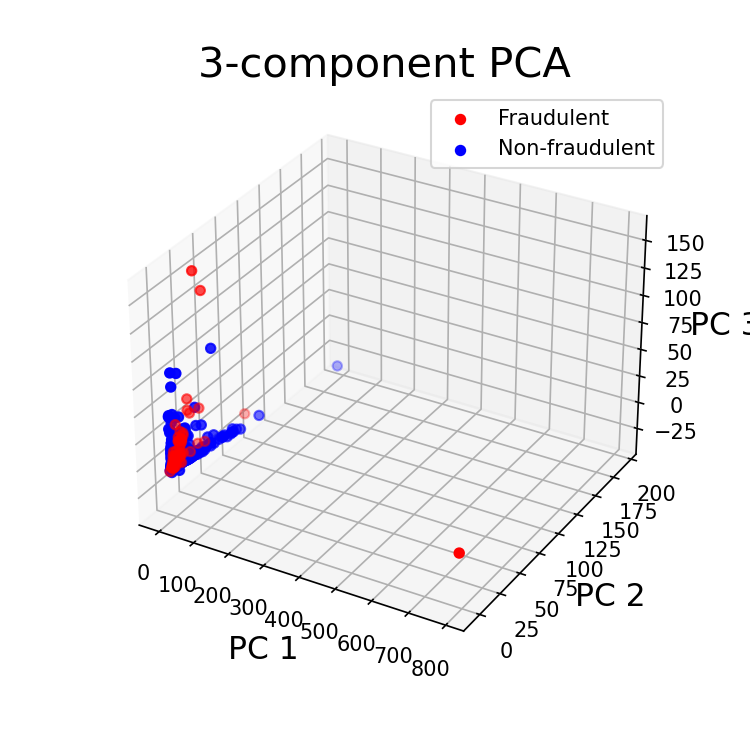

In [24]:
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)
pcdf = pd.DataFrame(data=pcs, columns=['pc1', 'pc2', 'pc3'])
pcdf['Fraudulent'] = data_merged_labeled['Fraudulent'].values

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.set_title('3-component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pcdf['Fraudulent'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , pcdf.loc[indicesToKeep, 'pc3'] 
               , c = color
               , s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

### K-means Clustering

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [26]:
X = data_merged_labeled.loc[:, data_merged_labeled.columns[0:-1]].values
y = data_merged_labeled.loc[:, 'Fraudulent'].values

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

y_true = y
y_pred = 1 - kmeans.labels_
cm = confusion_matrix(y_true, y_pred)
print(cm)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
print(precision, recall)

[[  75 2334]
 [   3   71]]
0.029521829521829523 0.9594594594594594


### Gaussian Mixture Model

In [27]:
from sklearn.mixture import GaussianMixture

In [28]:
X = data_merged_labeled.loc[:, data_merged_labeled.columns[0:-1]].values
y = data_merged_labeled.loc[:, 'Fraudulent'].values

gmm = GaussianMixture(n_components=2, covariance_type='full', reg_covar=1e-5, random_state=0).fit(X)
gmm_labels = gmm.predict(X)

y_true = y
y_pred = 1 - gmm_labels
cm = confusion_matrix(y_true, y_pred)
print(cm)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
print(precision, recall)

[[2336   73]
 [  71    3]]
0.039473684210526314 0.04054054054054054


### Local Outlier Factor (LOF)

In [29]:
from sklearn.neighbors import LocalOutlierFactor

In [31]:
X = data_merged_labeled.loc[:, data_merged_labeled.columns[0:-1]].values
y = data_merged_labeled.loc[:, 'Fraudulent'].values

clf = LocalOutlierFactor(n_neighbors=10)
y_prediction = clf.fit_predict(X)
X_scores = -clf.negative_outlier_factor_

y_true = y
y_pred = np.zeros(len(X_scores))
y_pred[X_scores > 1] = 1.0
cm = confusion_matrix(y_true, y_pred)
print(cm)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
print(precision, recall)

[[  32 2377]
 [   0   74]]
0.03019175846593227 1.0


# More Feature Engineering

We might be able to use our knowledge about what features represent and then extract more useful features from them. 

## A Naive Approach

We extract two features from the merged dataset: 1) Total amount of money a provider earned during 2012-2018 and 2) A variablity measure showing how a provider has changed their behaviour during 2012-2018 

In [17]:
X = data_merged_labeled.loc[:, data_merged_labeled.columns[0:-1]].values
y = data_merged_labeled.loc[:, 'Fraudulent'].values

X_sum = np.sum(X, axis=1)
X_std_matrix = np.zeros((X.shape[0], int(X.shape[1] / 7)))
for r in range(X_std_matrix.shape[0]):
    for c in range(X_std_matrix.shape[1]):
        X_std_matrix[r, c] = np.std(X[r, c * 7 : (c+1) * 7])
        if X_std_matrix[r, c] != 0:
            X_std_matrix[r, c] /= np.mean(X[r, c * 7 : (c+1) * 7])
X_std = np.mean(X_std_matrix, axis=1)

<IPython.core.display.Javascript object>


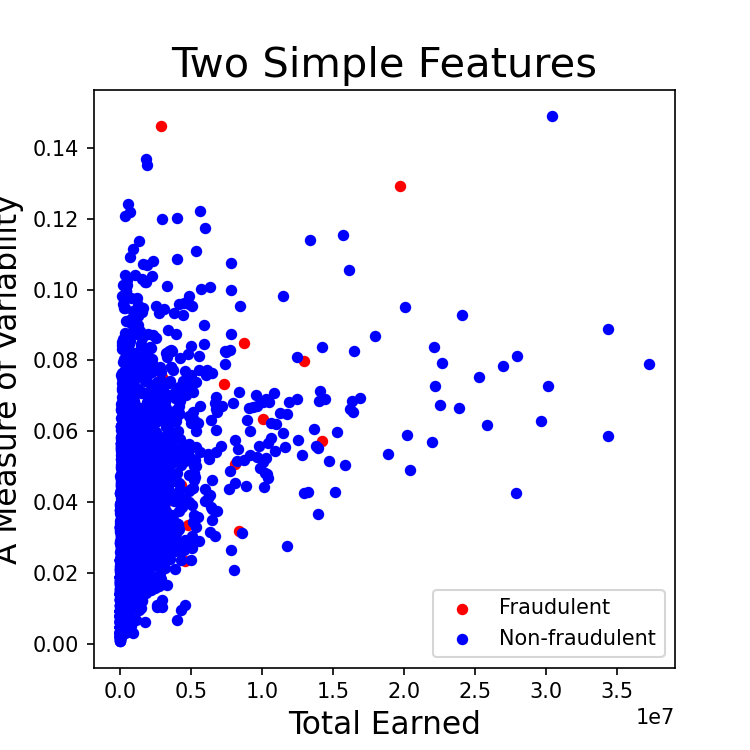

In [18]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Total Earned', fontsize = 15)
ax.set_ylabel('A Measure of Variability', fontsize = 15)
ax.set_title('Two Simple Features', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = (y == target)
    ax.scatter(X_sum[indicesToKeep]
               , X_std[indicesToKeep]
               , c = color
               , s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

## Removing the J code

In [19]:
clmns = list(data_merged_labeled.columns)
clmns_noJ = [hcpcs for hcpcs in clmns if hcpcs[0] != 'J']
data_merged_labeled_noJ = data_merged_labeled.loc[:, clmns_noJ]

X = data_merged_labeled_noJ.loc[:, data_merged_labeled_noJ.columns[0:-1]].values
y = data_merged_labeled_noJ.loc[:, 'Fraudulent'].values

## Using 2012 and 2013 Data

In [20]:
clmns = list(data_merged_labeled.columns)
clmns_2012_2013 = [hcpcs for hcpcs in clmns if hcpcs[-1] == '2' or hcpcs[-1] == '3' or hcpcs == 'Fraudulent']
data_merged_2012_2013 = data_merged_labeled.loc[:, clmns_2012_2013]